In [1]:
from PIL import Image
from pytesseract import pytesseract
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_img = input("image path: ")
img1 = np.array(Image.open(input_img))
cropped_im1 = img1[10:-10, 10:-10]
crop_img_copy = cropped_im1.copy()

#convert RGB to greyscale
gray1 = cv2.cvtColor(cropped_im1, cv2.COLOR_BGR2GRAY)

#Applying OTSU threshold to convert greyscale to Black and white
_, im12 = cv2.threshold(gray1, 128, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

image path: /media/mohit/NewVolume/projects/AdEase/Scraped_ads/example3.jpg


In [3]:
#checking the dominant color of the border to decide weather to inverse the binary or to keep it same
def check_dominant_border_color(img):
    row_1 = img[0, :]
    col_1 = img[:, 0]
    row_2 = img[-1, :]
    col_2 = img[:, -1]

    combined_li = row_1.tolist() + row_2.tolist() + col_1.tolist() + col_2.tolist()
    
    color_counter = Counter(combined_li)
    colors_keys = list(color_counter.keys())
    colors_values = list(color_counter.values())
    dominant_color = max(colors_keys, key=lambda x:colors_values)

    return dominant_color

dominant_color = check_dominant_border_color(im12)
if dominant_color!=0:
    im12 = 255-im12

In [4]:
#Get rectangular structures
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilation1 = cv2.dilate(im12, rect_kernel, iterations = 1)

In [5]:
contours1, hierarchy1 = cv2.findContours(dilation1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

### call of action button and Logo Detection

In [6]:
call_of_action = ['subscribe','seehow','watchnow','introduceus','registernow','next','buynow','startsharing','joinnow','getstarted','signup','signuphere',
                 'claimyourfreetrial','signmeup','shopnow','trynow']
brands = ['dell','adobe','parallels','paypal','adidas','jpmorgan','samsung','curiosity','curiositystream']

In [7]:
def text_extraction(org_img,thresh_img,contours,call_of_action,brands):    
    all_text = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = thresh_img[y:y + h, x:x + w]
        cropped = 255-cropped
        
        text = pytesseract.image_to_string(cropped, config='--oem 1 --psm 6')
        text_n = text.replace("\x0c","").replace("\n","").replace(" ","").lower()
        if len(text_n)<5:
            if len(cropped[0])>10 and len(cropped)>10:
                length = len(cropped)*12//100
                width = len(cropped[0])*12//100
                cropped = cropped[length:-length,width:-width]
                cropped = 255-cropped
                text = pytesseract.image_to_string(cropped, config='--oem 1 --psm 6')
                text_n = text.replace("\x0c","").replace("\n","").replace(" ","").lower()
            else:
                continue
        
        all_text.append(text)
        
        for button in call_of_action:
            if text_n==button:
                all_text.pop()
                print("********************************************")
                print("Call to action button: ", text)
                print("********************************************\n\n")
                crop_org = org_img[y:y + h, x:x + w]
                plt.figure()
                plt.title("Call_of_action_button")
                plt.imshow(crop_org)
                break
        for brand in brands:
            if text_n == brand:
                all_text.pop()
                print("********************************************")
                print("Logo: ", text)
                print("********************************************\n\n")
                crop_org = org_img[y:y + h, x:x + w]
                plt.figure()
                plt.title("Logo")
                plt.imshow(crop_org)
                break
    print("********************************************")
    print("Other Text: ", "\n".join(all_text))
    print("********************************************")

********************************************
Call to action button:  WATCH NOW

********************************************


********************************************
Logo:  Curiosity

********************************************


********************************************
Other Text:  
|



Thousands of
documentaries & movies

= =
s

aan : betty ¢
pig QM es .

********************************************


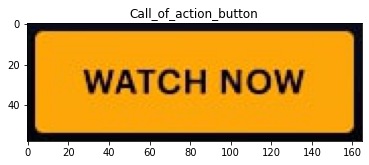

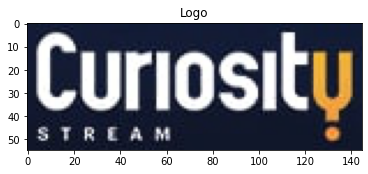

In [8]:
text_extraction(cropped_im1,im12,contours1, call_of_action,brands)